NEW


In [1]:
!pip install --upgrade tensorflow mediapipe opencv-python scikit-learn ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mediapipe to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.0/645.0 MB 785.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 103.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.1 MB/s eta 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Класи: ['Hold', 'Idle', 'Intent_Grasp', 'Intent_Release'] | прикладів: 1200
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
class_weight: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8

[Callback] val_macro_f1: 0.3601
30/30 - 217s - 7s/step - accuracy: 0.3063 - loss: 1.6563 - val_accuracy: 0.3833 - val_loss: 2.0474 - val_macro_f1: 0.3601 - learning_rate: 2.8858e-04
Epoch 2/8

[Callback] val_macro_f1: 0.4090
30/30 - 190s - 6s/step - accuracy: 0.4240 - loss: 1.4036 - val_accuracy: 0.4125 - val_loss: 1.5847 - val_macro_f1: 0.4090 - learning_rate: 2.5607e-04
Epoch 3/8

[Callback] val_macro_f1: 0.3760
30/30 - 182s - 6s/step - accuracy: 0.4812 - loss: 1.3111 - val_accuracy: 0.3792 - val_loss: 1.4977 - val_macro_f1: 0.3760 - learning_rate: 2.0740e-04
Epoch 4/8

[Callback] val_macro_f1: 0.4556
30/30 - 202s - 7s/step - accuracy: 0.5365 - loss: 1.1675 - val_accuracy: 0.4667 - val_loss: 1.2375 - val_macro_f1: 0.4556 - learning_rate: 1.5000e-04
Epoch 5/8

[Callback] val_macro_f1: 0.4667
30/30 - 202s - 7s/step - accuracy: 0.5312 - loss: 1.1808 - val_accuracy: 0.4708 - val_loss: 1.2504 - val_macro_f1: 0.4667 - learning_rate: 9.2597e-05
Epoch 6/8

[Callback] val_macro_f1:

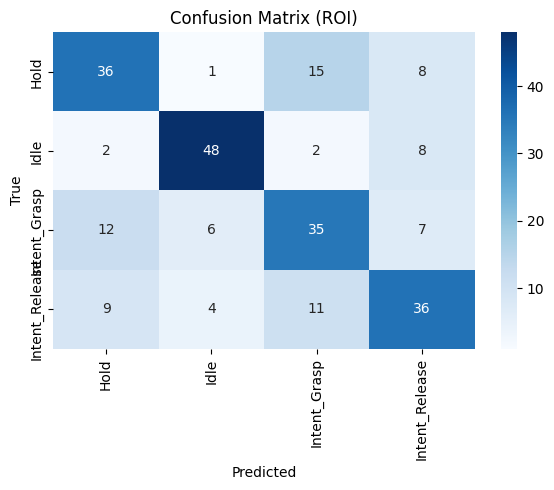

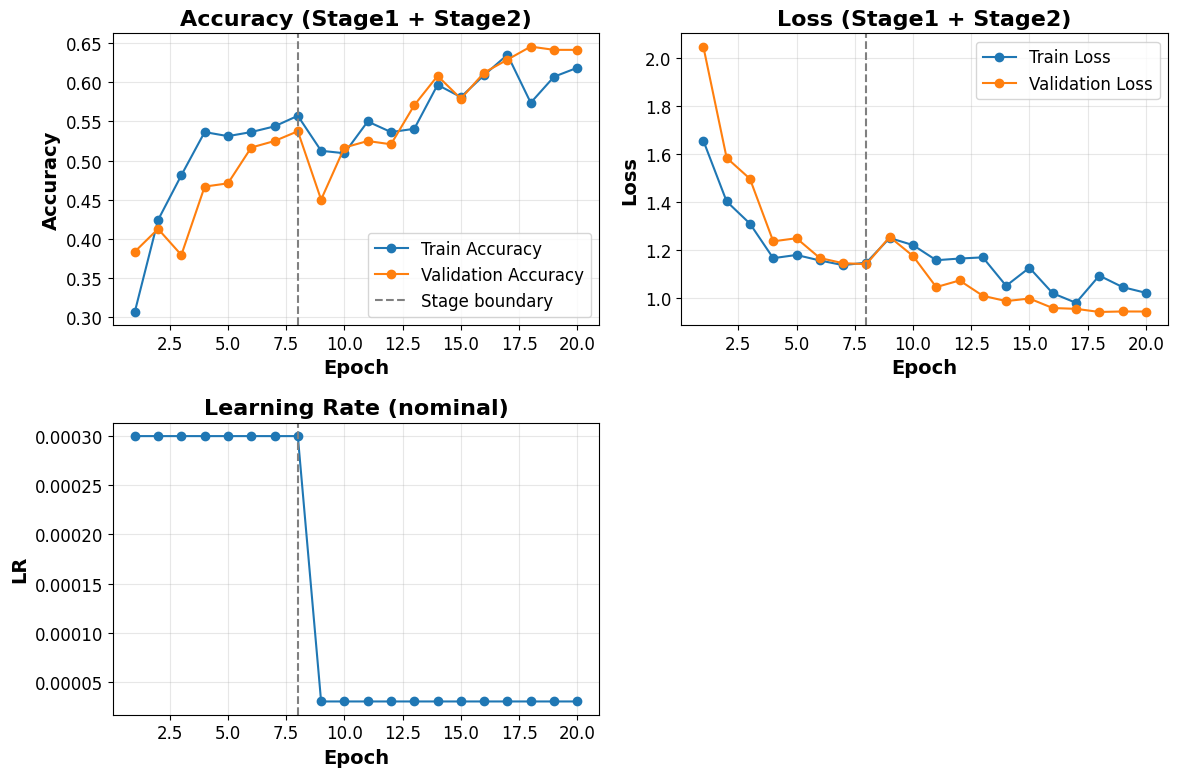

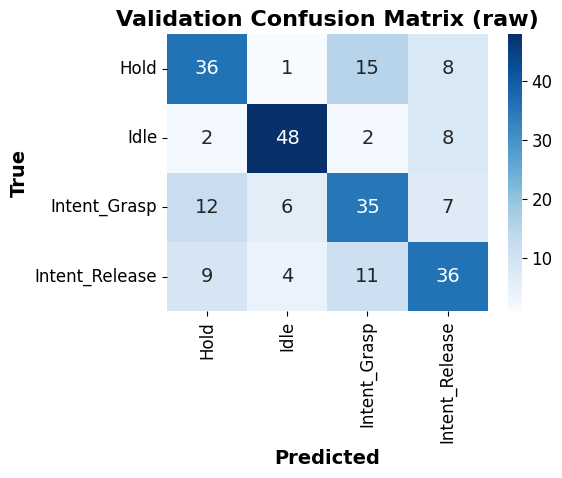

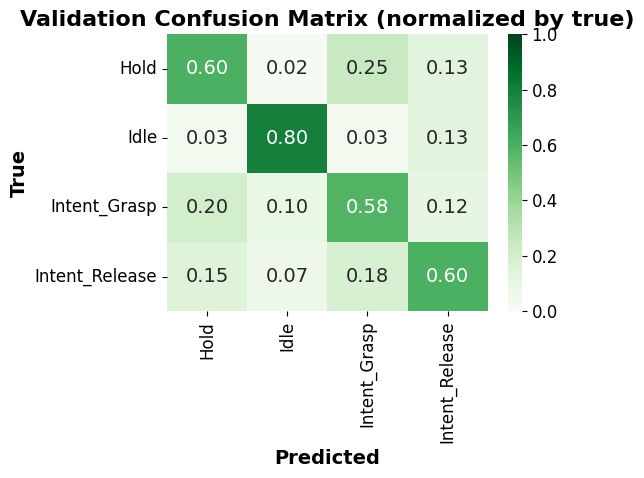

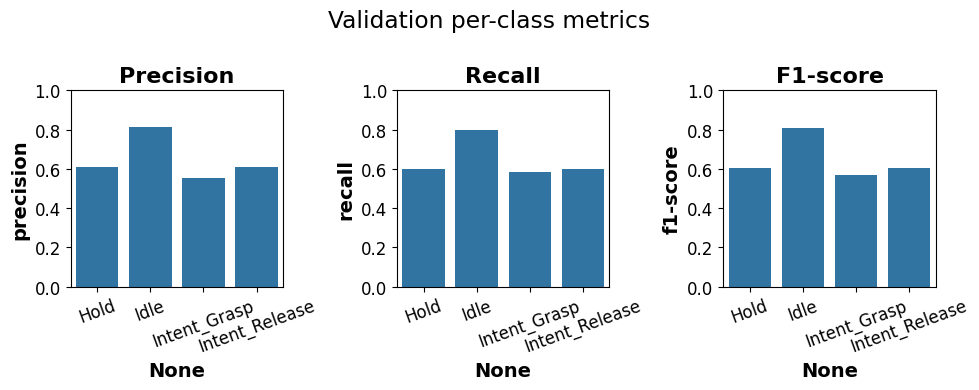

[VAL] Overall accuracy: 0.646  |  Macro-F1: 0.646


In [2]:
# ===================== CONFIG & IMPORTS =====================
import os, math, random, cv2, numpy as np, tensorflow as tf
from typing import List, Tuple
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from tensorflow.keras import layers, regularizers, Model
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import mobilenet, mobilenet_v2, resnet_v2

import mediapipe as mp
mp_hands = mp.solutions.hands

# ===== reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# ===== WHAT TO TRAIN: "mobilenet", "mobilenet_v2", "resnet50v2"
MODEL_NAME     = "mobilenet_v2"        # <-- змінюй тут
UNFREEZE_LAST  = 120                 # більше шарів для Stage 2
LABEL_SMOOTH   = 0.01                # було 0.10
USE_FOCAL_LOSS = False                # можна вимкнути, якщо треба CE

# ===== Paths & Data
DATA_DIR   = "/content/drive/MyDrive/MARISOVA_AI_HAND_PROJECT/Gestures_Dataset"
VAL_SPLIT  = 0.2
BATCH_SIZE = 32

# ===== ROI / Aug
MARGIN     = 1.8                    # ширше навколо руки (було 1.10)
AUG        = True

# ===== IMG_SIZE (підняли для ResNet)
if MODEL_NAME == "mobilenet":
    IMG_SIZE = (224, 224)
elif MODEL_NAME == "mobilenet_v2":
    IMG_SIZE = (224, 224)            # 160 або 224
else:  # resnet50v2
    IMG_SIZE = (256, 256)            # ↑ з 224

# ===================== DATA SCAN =====================
def list_images_with_labels(root: str) -> Tuple[List[str], List[int], List[str]]:
    class_names = sorted([d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))])
    paths, labels = [], []
    for ci, cname in enumerate(class_names):
        cdir = os.path.join(root, cname)
        for fn in sorted(os.listdir(cdir)):
            if fn.lower().endswith((".jpg",".jpeg",".png",".bmp",".webp")):
                p = os.path.join(cdir, fn)
                if cv2.haveImageReader(p):
                    paths.append(p); labels.append(ci)
    return paths, labels, class_names

paths_all, labels_all, CLASS_NAMES = list_images_with_labels(DATA_DIR)
print(f"Класи: {CLASS_NAMES} | прикладів: {len(paths_all)}")

X_tr, X_val, y_tr, y_val = train_test_split(
    paths_all, labels_all, test_size=VAL_SPLIT, stratify=labels_all, random_state=SEED
)

# ===================== ROI HELPERS (MediaPipe) =====================
def largest_hand_bbox_from_landmarks(img: np.ndarray, lms_list):
    h, w = img.shape[:2]
    best = None
    for lm in lms_list:
        xs = [int(p.x*w) for p in lm.landmark]
        ys = [int(p.y*h) for p in lm.landmark]
        x1, y1, x2, y2 = max(min(xs),0), max(min(ys),0), min(max(xs),w-1), min(max(ys),h-1)
        area = max(1,(x2-x1)*(y2-y1))
        if best is None or area > best[-1]:
            best = (x1, y1, x2, y2, area)
    if best is None:
        cx, cy = w//2, h//2; sz = min(w,h)//3
        return cx-sz, cy-sz, cx+sz, cy+sz
    x1,y1,x2,y2,_ = best
    cx, cy = (x1+x2)/2, (y1+y2)/2
    bw, bh = (x2-x1)*MARGIN, (y2-y1)*MARGIN
    x1n, y1n = int(max(0, cx-bw/2)), int(max(0, cy-bh/2))
    x2n, y2n = int(min(w-1, cx+bw/2)), int(min(h-1, cy+bh/2))
    return x1n, y1n, x2n, y2n

def crop_hand_roi(img: np.ndarray, hands_ctx) -> np.ndarray:
    h, w = img.shape[:2]
    res = hands_ctx.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if res.multi_hand_landmarks:
        x1,y1,x2,y2 = largest_hand_bbox_from_landmarks(img, res.multi_hand_landmarks)
    else:
        cx, cy = w//2, h//2; sz = min(w,h)//3
        x1,y1,x2,y2 = cx-sz, cy-sz, cx+sz, cy+sz
    roi = img[max(0,y1):min(h,y2), max(0,x1):min(w,x2)]
    if roi.size == 0: roi = img
    rh, rw = roi.shape[:2]
    side = max(rh, rw)
    pad_top = (side-rh)//2; pad_bottom = side-rh-pad_top
    pad_left = (side-rw)//2; pad_right = side-rw-pad_left
    roi = cv2.copyMakeBorder(roi, pad_top, pad_bottom, pad_left, pad_right,
                             borderType=cv2.BORDER_CONSTANT, value=(0,0,0))
    roi = cv2.resize(roi, IMG_SIZE, interpolation=cv2.INTER_AREA)
    return roi

# ----- augmentations (blur + cutout + базові геометричні)
def random_cutout(img, max_frac=0.22):
    h, w = img.shape[:2]
    if np.random.rand() < 0.5:
        cw = int(np.random.uniform(0.05, max_frac)*w)
        ch = int(np.random.uniform(0.05, max_frac)*h)
        x1 = np.random.randint(0, w-cw+1); y1 = np.random.randint(0, h-ch+1)
        img[y1:y1+ch, x1:x1+cw] = 0
    return img

def augment_rgb(img: np.ndarray) -> np.ndarray:
    h, w = img.shape[:2]
    if np.random.rand() < 0.5: img = cv2.flip(img, 1)
    if np.random.rand() < 0.5:
        ang = np.random.uniform(-20, 20)
        M = cv2.getRotationMatrix2D((w//2, h//2), ang, 1.0)
        img = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT101)
    if np.random.rand() < 0.4:
        tx = int(np.random.uniform(-0.10*w, 0.10*w))
        ty = int(np.random.uniform(-0.10*h, 0.10*h))
        M = np.float32([[1,0,tx],[0,1,ty]])
        img = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT101)
    if np.random.rand() < 0.4:
        sc = np.random.uniform(0.9, 1.1)
        M = cv2.getRotationMatrix2D((w//2, h//2), 0, sc)
        img = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT101)
    if np.random.rand() < 0.5:
        alpha = np.random.uniform(0.85, 1.20); beta = np.random.randint(-20, 20)
        img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
    # легкий gaussian blur як імітація зйомки у русі/стрімі
    if np.random.rand() < 0.3:
        k = np.random.choice([3,5])
        img = cv2.GaussianBlur(img, (k,k), 0)
    img = random_cutout(img)
    return img

# ===================== UNIVERSAL BACKBONE BUILDER =====================
def build_backbone(model_name: str, img_size, num_classes: int):
    name = model_name.lower()
    if name == "mobilenet":
        base = mobilenet.MobileNet(weights="imagenet", include_top=False,
                                   input_shape=(*img_size, 3))
        preprocess_fn = mobilenet.preprocess_input
    elif name == "mobilenet_v2":
        base = mobilenet_v2.MobileNetV2(weights="imagenet", include_top=False,
                                        input_shape=(*img_size, 3))
        preprocess_fn = mobilenet_v2.preprocess_input
    elif name == "resnet50v2":
        base = resnet_v2.ResNet50V2(weights="imagenet", include_top=False,
                                    input_shape=(*img_size, 3))
        preprocess_fn = resnet_v2.preprocess_input
    else:
        raise ValueError(f"Unknown MODEL_NAME: {model_name}")
    base.trainable = False

    inp = layers.Input(shape=(*img_size, 3))
    x = base(inp, training=False)

    # improved head: GAP + GMP -> concat
    x_avg = layers.GlobalAveragePooling2D()(x)
    x_max = layers.GlobalMaxPooling2D()(x)
    x = layers.Concatenate()([x_avg, x_max])

    x = layers.Dense(256, kernel_regularizer=regularizers.l2(1e-5))(x)  # слабший L2
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)  # менший dropout
    out = layers.Dense(num_classes, activation='softmax')(x)
    model = Model(inp, out)
    return model, base, preprocess_fn

# ===================== SEQUENCE (ROI + preprocess_fn + MixUp) =====================
def mixup(X, y, alpha=0.2):
    if alpha is None or alpha <= 0 or len(X) < 2:
        return X, y
    lam = np.random.beta(alpha, alpha)
    idx = np.random.permutation(len(X))
    Xm = lam*X + (1-lam)*X[idx]
    ym = lam*y + (1-lam)*y[idx]
    return Xm, ym

class ROICropSequence(Sequence):
    def __init__(self, paths, labels, batch_size, shuffle, augment,
                 num_classes, preprocess_fn):
        self.paths  = list(paths)
        self.labels = np.array(labels, dtype=np.int32)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.num_classes = num_classes
        self.preprocess_fn = preprocess_fn
        self.idxs = np.arange(len(self.paths))
        self.hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1,
                                    min_detection_confidence=0.5)
        self.on_epoch_end()

    def __len__(self): return math.ceil(len(self.paths)/self.batch_size)
    def on_epoch_end(self):
        if self.shuffle: np.random.shuffle(self.idxs)

    def _process_one(self, j):
        p = self.paths[j]
        img = cv2.imread(p)
        if img is None: return None
        roi = crop_hand_roi(img, self.hands)
        if self.augment: roi = augment_rgb(roi)
        roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB).astype(np.float32)
        roi = self.preprocess_fn(roi)
        return roi, self.labels[j]

    def __getitem__(self, i):
        ids = self.idxs[i*self.batch_size:(i+1)*self.batch_size]
        X, y = [], []
        for j in ids:
            item = self._process_one(j)
            if item is None: continue
            xi, yi = item; X.append(xi); y.append(yi)
        if len(X) == 0:
            for j in range(len(self.paths)):
                item = self._process_one(j)
                if item is not None:
                    xi, yi = item; X=[xi]; y=[yi]; break
            if len(X)==0: raise ValueError("ROICropSequence: немає валідних зображень.")
        X = np.stack(X, axis=0)
        y = tf.keras.utils.to_categorical(np.array(y), num_classes=self.num_classes)

        # MixUp тільки на train
        if self.augment:
            X, y = mixup(X, y, alpha=0.2)
        return X, y

    def close(self): self.hands.close()

# ===================== FOCAL LOSS (опційно) =====================
class CategoricalFocalLoss(tf.keras.losses.Loss):
    def __init__(self, gamma=2.0, alpha=None, label_smoothing=0.0):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.ce = tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing)

    def call(self, y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0-1e-7)
        ce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        pt = tf.reduce_sum(y_true * y_pred, axis=-1)
        focal = tf.pow(1. - pt, self.gamma) * ce
        if self.alpha is not None:
            alpha_w = tf.reduce_sum(y_true * tf.constant(self.alpha, dtype=y_true.dtype), axis=-1)
            focal *= alpha_w
        return focal

# ===================== BUILD MODEL & DATA LOADERS =====================
num_classes = len(CLASS_NAMES)
model, base, PREPROC = build_backbone(MODEL_NAME, IMG_SIZE, num_classes)

train_seq = ROICropSequence(X_tr, y_tr, batch_size=BATCH_SIZE, shuffle=True,
                            augment=True, num_classes=num_classes, preprocess_fn=PREPROC)
val_seq   = ROICropSequence(X_val, y_val, batch_size=BATCH_SIZE, shuffle=False,
                            augment=False, num_classes=num_classes, preprocess_fn=PREPROC)

# підсилимо Intent-класи
hard = {"Intent_Grasp", "Intent_Release"}
CLASS_WEIGHT = {i: (1.0 if CLASS_NAMES[i] in hard else 1.0) for i in range(num_classes)}
print("class_weight:", CLASS_WEIGHT)

# ===================== MACRO-F1 CALLBACK (рахує на вал і логить у logs) =====================
class MacroF1Callback(tf.keras.callbacks.Callback):
    def __init__(self, val_seq, name='val_macro_f1'):
        super().__init__()
        self.val_seq = val_seq
        self.name = name
    def on_epoch_end(self, epoch, logs=None):
        y_true, y_pred = [], []
        for b in range(len(self.val_seq)):
            Xb, yb = self.val_seq[b]
            prob = self.model.predict(Xb, verbose=0)
            y_true.extend(np.argmax(yb, axis=1))
            y_pred.extend(np.argmax(prob, axis=1))
        m = f1_score(y_true, y_pred, average='macro')
        logs = logs or {}
        logs[self.name] = m
        print(f"\n[Callback] {self.name}: {m:.4f}")

macro_cb = MacroF1Callback(val_seq)

# ===================== LOSS & OPTIMIZER (Stage 1) =====================
if USE_FOCAL_LOSS:
    # вектор alpha в порядку CLASS_NAMES
    alpha_vec = [1.0 if cls not in hard else 1.5 for cls in CLASS_NAMES]
    loss_obj = CategoricalFocalLoss(gamma=2.0, alpha=alpha_vec, label_smoothing=LABEL_SMOOTH)
else:
    loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTH)

steps_per_epoch = max(1, len(train_seq))
lr1 = CosineDecay(initial_learning_rate=3e-4, decay_steps=steps_per_epoch*8)  # ~8 епох
opt1 = AdamW(learning_rate=lr1, weight_decay=1e-4)
model.compile(optimizer=opt1, loss=loss_obj, metrics=['accuracy'])

ckpt_dir = "/content/drive/MyDrive/MARISOVA_AI_HAND_PROJECT/models"
os.makedirs(ckpt_dir, exist_ok=True)
ckpt_path = f"{ckpt_dir}/{MODEL_NAME}_roi_best.keras"

cbs_stage1 = [
    macro_cb,
    tf.keras.callbacks.ModelCheckpoint(ckpt_path, save_best_only=True,
                                       monitor='val_macro_f1', mode='max'),
    tf.keras.callbacks.EarlyStopping(monitor='val_macro_f1', mode='max',
                                     patience=8, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                         patience=3, min_lr=1e-6, verbose=1)
]

hist1 = model.fit(train_seq, validation_data=val_seq,
                  epochs=8, class_weight=CLASS_WEIGHT, callbacks=cbs_stage1, verbose=2)

# ===================== TRAIN: Stage 2 (fine-tune tail) =====================
for layer in base.layers[-UNFREEZE_LAST:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

# менший LR для всього, бо вже розморожено основу
lr2 = CosineDecay(initial_learning_rate=3e-5, decay_steps=steps_per_epoch*12)
opt2 = AdamW(learning_rate=lr2, weight_decay=1e-4)
model.compile(optimizer=opt2, loss=loss_obj, metrics=['accuracy'])

# новий macro-callback (щоб перезапустити внутрішній буфер, хоча тут це не критично)
macro_cb2 = MacroF1Callback(val_seq)

cbs_stage2 = [
    macro_cb2,
    tf.keras.callbacks.ModelCheckpoint(ckpt_path, save_best_only=True,
                                       monitor='val_macro_f1', mode='max'),
    tf.keras.callbacks.EarlyStopping(monitor='val_macro_f1', mode='max',
                                     patience=8, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                         patience=3, min_lr=1e-6, verbose=1)
]

hist2 = model.fit(train_seq, validation_data=val_seq,
                  epochs=12, class_weight=CLASS_WEIGHT, callbacks=cbs_stage2, verbose=2)

print("Best model saved to:", ckpt_path)

# ===================== EVALUATION on VAL =====================
y_true_list, y_pred_list, y_prob_list = [], [], []
for b in range(len(val_seq)):
    Xb, yb = val_seq[b]
    prob = model.predict(Xb, verbose=0)
    y_prob_list.append(prob)
    y_true_list.extend(np.argmax(yb, axis=1))
    y_pred_list.extend(np.argmax(prob, axis=1))

y_true = np.array(y_true_list)
y_pred = np.array(y_pred_list)
y_prob = np.concatenate(y_prob_list, axis=0)

print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=3))

cm = confusion_matrix(y_true, y_pred, labels=list(range(len(CLASS_NAMES))))
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix (ROI)")
plt.tight_layout(); plt.show()

# ===================== TRAINING CURVES (Stage1 + Stage2) =====================
plt.rcParams.update({
    "font.size": 14,
    "axes.labelweight": "bold",
    "axes.titlesize": 16,
    "axes.titleweight": "bold",
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "grid.alpha": 0.3
})

epochs_all = range(1, len(hist1.history['accuracy']) + len(hist2.history['accuracy']) + 1)
train_acc = hist1.history['accuracy'] + hist2.history['accuracy']
val_acc   = hist1.history['val_accuracy'] + hist2.history['val_accuracy']
train_loss = hist1.history['loss'] + hist2.history['loss']
val_loss   = hist1.history['val_loss'] + hist2.history['val_loss']

stage_boundary = len(hist1.history['accuracy'])
lr_curve = [3e-4]*stage_boundary + [3e-5]*len(hist2.history['loss'])

fig, axs = plt.subplots(2, 2, figsize=(12,8))

axs[0,0].plot(epochs_all, train_acc, '-o', label='Train Accuracy')
axs[0,0].plot(epochs_all, val_acc, '-o', label='Validation Accuracy')
axs[0,0].axvline(stage_boundary, color='gray', linestyle='--', label='Stage boundary')
axs[0,0].set_title("Accuracy (Stage1 + Stage2)")
axs[0,0].set_xlabel("Epoch"); axs[0,0].set_ylabel("Accuracy")
axs[0,0].legend(); axs[0,0].grid(True)

axs[0,1].plot(epochs_all, train_loss, '-o', label='Train Loss')
axs[0,1].plot(epochs_all, val_loss, '-o', label='Validation Loss')
axs[0,1].axvline(stage_boundary, color='gray', linestyle='--')
axs[0,1].set_title("Loss (Stage1 + Stage2)")
axs[0,1].set_xlabel("Epoch"); axs[0,1].set_ylabel("Loss")
axs[0,1].legend(); axs[0,1].grid(True)

axs[1,0].plot(epochs_all, lr_curve, '-o')
axs[1,0].axvline(stage_boundary, color='gray', linestyle='--')
axs[1,0].set_title("Learning Rate (nominal)")
axs[1,0].set_xlabel("Epoch"); axs[1,0].set_ylabel("LR")
axs[1,0].grid(True)

axs[1,1].axis("off")
plt.tight_layout(); plt.show()

# ======= РОЗШИРЕНИЙ VAL-РЕПОРТ + ПЛОТИ =======
report_str = classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=3)
cm_raw = confusion_matrix(y_true, y_pred, labels=list(range(len(CLASS_NAMES))))
cm_norm = cm_raw.astype(float) / (cm_raw.sum(axis=1, keepdims=True) + 1e-12)

plt.figure(figsize=(6,5))
sns.heatmap(cm_raw, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title("Validation Confusion Matrix (raw)"); plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, vmin=0, vmax=1)
plt.title("Validation Confusion Matrix (normalized by true)"); plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

report_dict = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True)
df_scores = pd.DataFrame({m: [report_dict[c][m] for c in CLASS_NAMES]
                          for m in ['precision','recall','f1-score']},
                         index=CLASS_NAMES)

plt.figure(figsize=(10,4))
plt.subplot(1,3,1); sns.barplot(x=df_scores.index, y=df_scores['precision']); plt.title('Precision'); plt.ylim(0,1); plt.xticks(rotation=20)
plt.subplot(1,3,2); sns.barplot(x=df_scores.index, y=df_scores['recall']);    plt.title('Recall');    plt.ylim(0,1); plt.xticks(rotation=20)
plt.subplot(1,3,3); sns.barplot(x=df_scores.index, y=df_scores['f1-score']);  plt.title('F1-score');  plt.ylim(0,1); plt.xticks(rotation=20)
plt.suptitle("Validation per-class metrics"); plt.tight_layout(); plt.show()

overall_acc = (y_true == y_pred).mean()
macro_f1 = df_scores['f1-score'].mean()
print(f"[VAL] Overall accuracy: {overall_acc:.3f}  |  Macro-F1: {macro_f1:.3f}")

# ====== ЗБЕРЕЖЕННЯ РЕПОРТУ ======
SAVE_DIR = "/content/drive/MyDrive/MARISOVA_AI_HAND_PROJECT/reports"
os.makedirs(SAVE_DIR, exist_ok=True)
with open(os.path.join(SAVE_DIR, "val_report.txt"), "w", encoding="utf-8") as f:
    f.write("=== VALIDATION REPORT (ROI CNN, improved) ===\n\n")
    f.write(report_str + "\n")
    f.write(f"\nOverall accuracy: {overall_acc:.3f}\nMacro-F1: {macro_f1:.3f}\n")

# закриваємо MediaPipe контексти
train_seq.close(); val_seq.close()


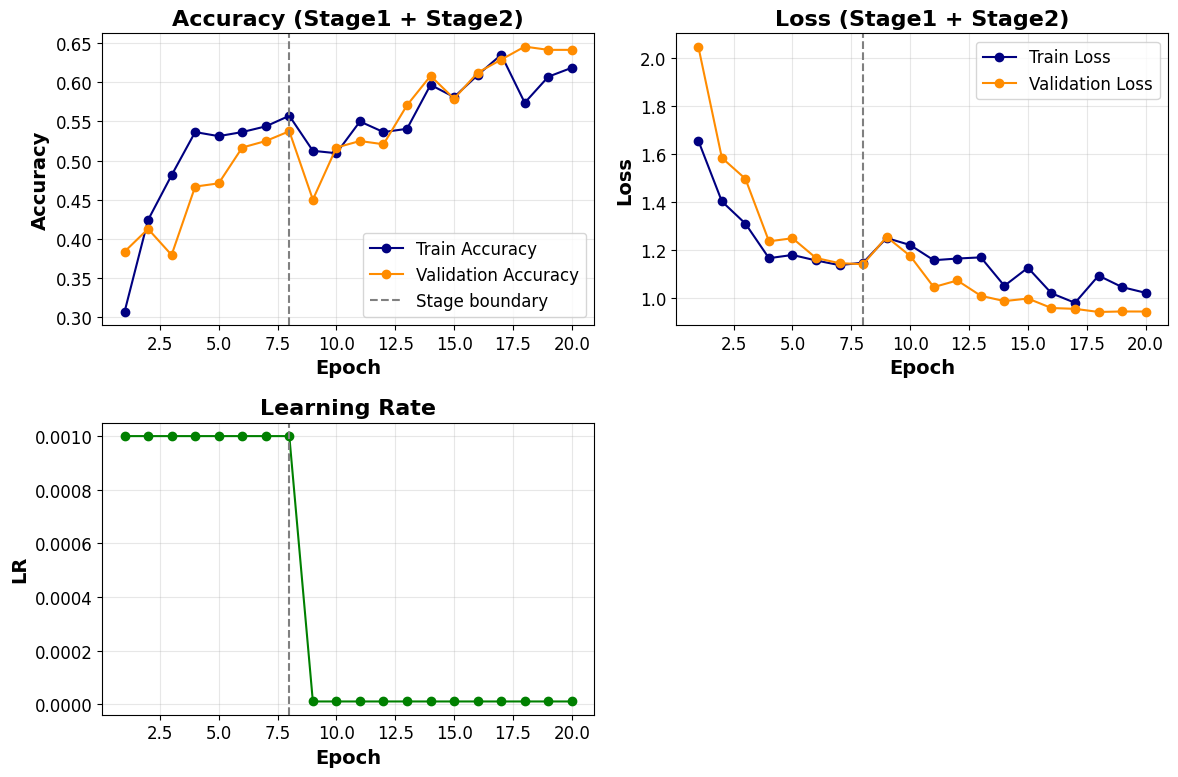

In [3]:
# ======= TRAINING CURVES (Stage1 + Stage2) =======

import matplotlib.pyplot as plt


# встановимо стиль
plt.rcParams.update({
    "font.family": "",
    "font.size": 14,
    "axes.labelweight": "bold",
    "axes.titlesize": 16,
    "axes.titleweight": "bold",
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "grid.alpha": 0.3
})

epochs = range(1, len(hist1.history['accuracy']) + len(hist2.history['accuracy']) + 1)

# Об'єднаємо Stage1+Stage2
train_acc = hist1.history['accuracy'] + hist2.history['accuracy']
val_acc   = hist1.history['val_accuracy'] + hist2.history['val_accuracy']
train_loss = hist1.history['loss'] + hist2.history['loss']
val_loss   = hist1.history['val_loss'] + hist2.history['val_loss']

# навчальний rate (просто приклад: якщо зменшувався після stage1)
lr = [1e-3]*len(hist1.history['loss']) + [1e-5]*len(hist2.history['loss'])

fig, axs = plt.subplots(2, 2, figsize=(12,8))

# Accuracy
axs[0,0].plot(epochs, train_acc, '-o', label='Train Accuracy', color='navy')
axs[0,0].plot(epochs, val_acc, '-o', label='Validation Accuracy', color='darkorange')
axs[0,0].axvline(len(hist1.history['accuracy']), color='gray', linestyle='--', label='Stage boundary')
axs[0,0].set_title("Accuracy (Stage1 + Stage2)")
axs[0,0].set_xlabel("Epoch"); axs[0,0].set_ylabel("Accuracy")
axs[0,0].legend(); axs[0,0].grid(True)

# Loss
axs[0,1].plot(epochs, train_loss, '-o', label='Train Loss', color='navy')
axs[0,1].plot(epochs, val_loss, '-o', label='Validation Loss', color='darkorange')
axs[0,1].axvline(len(hist1.history['loss']), color='gray', linestyle='--')
axs[0,1].set_title("Loss (Stage1 + Stage2)")
axs[0,1].set_xlabel("Epoch"); axs[0,1].set_ylabel("Loss")
axs[0,1].legend(); axs[0,1].grid(True)

# Learning Rate
axs[1,0].plot(epochs, lr, '-o', color='green')
axs[1,0].axvline(len(hist1.history['loss']), color='gray', linestyle='--')
axs[1,0].set_title("Learning Rate")
axs[1,0].set_xlabel("Epoch"); axs[1,0].set_ylabel("LR")
axs[1,0].grid(True)

axs[1,1].axis("off")

plt.tight_layout()
plt.show()


In [4]:
# ===== PREVIEW CORRECT / WRONG ON A FRESH EVAL SEQUENCE =====

# 0) зробимо «свіжу» послідовність, щоб мати живий MediaPipe Hands
val_seq_preview = ROICropSequence(
    X_val, y_val,
    batch_size=BATCH_SIZE,
    shuffle=False,
    augment=False,
    num_classes=len(CLASS_NAMES),
    preprocess_fn=PREPROC
)

# 1) інверсія preprocess_input -> назад у [0..255] (для MobileNet/MobileNetV2/ResNetV2)
def deprocess_img(x):
    # для цих бекбонів preprocess дає [-1..1]
    x = np.clip((x + 1.0) * 127.5, 0, 255).astype(np.uint8)
    return x

# 2) зберемо всі батчі
X_all, y_true_all, prob_all = [], [], []
for b in range(len(val_seq_preview)):
    Xb, yb = val_seq_preview[b]         # препроцеснуті ROI та one-hot y
    pb = model.predict(Xb, verbose=0)   # ймовірності
    X_all.append(Xb)
    y_true_all.append(np.argmax(yb, axis=1))
    prob_all.append(pb)

# можна закрити прев’ю-послідовність, ми вже все зібрали
val_seq_preview.close()

X_all = np.concatenate(X_all, axis=0)
y_true_all = np.concatenate(y_true_all, axis=0)
prob_all = np.concatenate(prob_all, axis=0)

y_pred_all = np.argmax(prob_all, axis=1)
conf_all   = prob_all[np.arange(len(prob_all)), y_pred_all]

# 3) індекси
idx_correct = np.where(y_pred_all == y_true_all)[0]
idx_wrong   = np.where(y_pred_all != y_true_all)[0]

# відсортуємо: найвпевненіші спочатку
idx_correct = idx_correct[np.argsort(-conf_all[idx_correct])]
idx_wrong   = idx_wrong[np.argsort(-conf_all[idx_wrong])]

# 4) візуалізація
import math
import matplotlib.pyplot as plt

def show_grid(indices, title, k=16, cols=4, figsize=(12, 3*4)):
    m = min(k, len(indices))
    rows = math.ceil(m / cols)
    fig, axs = plt.subplots(rows, cols, figsize=figsize)
    axs = np.array(axs).reshape(rows, cols)

    for i in range(rows*cols):
        r, c = divmod(i, cols)
        ax = axs[r, c]
        if i < m:
            idx = indices[i]
            img = deprocess_img(X_all[idx])
            t = CLASS_NAMES[y_true_all[idx]]
            p = CLASS_NAMES[y_pred_all[idx]]
            conf = conf_all[idx]
            ax.imshow(img)
            ax.set_title(f"T:{t} | P:{p} ({conf:.2f})", fontsize=11)
            ax.axis('off')
        else:
            ax.axis('off')
    plt.suptitle(title, fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

show_grid(idx_correct, "CORRECT predictions (top-confident)", k=16)
show_grid(idx_wrong,   "MISCLASSIFIED predictions (top-confident errors)", k=16)


Output hidden; open in https://colab.research.google.com to view.